In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

In [18]:
df_raw = pd.read_csv('dataset/male_players.csv')
df_raw.head()

,Unnamed: 0,Name,Nation,Club,Position,Age,Overall,Pace,Shooting,Passing,...,Strength,Aggression,Att work rate,Def work rate,Preferred foot,Weak foot,Skill moves,URL,Gender,GK
0,0,Kylian Mbappé,France,Paris SG,ST,24,91,97,90,80,...,77,64,High,Low,Right,4,5,https://www.ea.com/games/ea-sports-fc/ratings/...,M,NaN
1,1,Erling Haaland,Norway,Manchester City,ST,23,91,89,93,66,...,93,87,High,Medium,Left,3,3,https://www.ea.com/games/ea-sports-fc/ratings/...,M,NaN
2,2,Kevin De Bruyne,Belgium,Manchester City,CM,32,91,72,88,94,...,74,75,High,Medium,Right,5,4,https://www.ea.com/games/ea-sports-fc/ratings/...,M,NaN
3,3,Lionel Messi,Argentina,Inter Miami CF,CF,36,90,80,87,90,...,68,44,Low,Low,Left,4,4,https://www.ea.com/games/ea-sports-fc/ratings/...,M,NaN
4,4,Karim Benzema,France,Al Ittihad,CF,35,90,79,88,83,...,82,63,Medium,Medium,Right,4,4,https://www.ea.com/games/ea-sports-fc/ratings/...,M,NaN


In [19]:
df = df_raw.drop(['Unnamed: 0','URL', 'Gender','GK'],axis=1)
df.head()

,Name,Nation,Club,Position,Age,Overall,Pace,Shooting,Passing,Dribbling,...,Sliding,Jumping,Stamina,Strength,Aggression,Att work rate,Def work rate,Preferred foot,Weak foot,Skill moves
0,Kylian Mbappé,France,Paris SG,ST,24,91,97,90,80,93,...,32,88,88,77,64,High,Low,Right,4,5
1,Erling Haaland,Norway,Manchester City,ST,23,91,89,93,66,79,...,29,93,76,93,87,High,Medium,Left,3,3
2,Kevin De Bruyne,Belgium,Manchester City,CM,32,91,72,88,94,86,...,53,72,88,74,75,High,Medium,Right,5,4
3,Lionel Messi,Argentina,Inter Miami CF,CF,36,90,80,87,90,96,...,24,71,70,68,44,Low,Low,Left,4,4
4,Karim Benzema,France,Al Ittihad,CF,35,90,79,88,83,87,...,18,85,82,82,63,Medium,Medium,Right,4,4


In [20]:
df['Position'].unique()

array(['ST', 'CM', 'CF', 'GK', 'RW', 'CB', 'LW', 'CDM', 'CAM', 'RM', 'LB',
       'RB', 'LM', 'LWB', 'RWB'], dtype=object)

Generation 1, Best Fitness: 168
Generation 2, Best Fitness: 211
Generation 3, Best Fitness: 235
Generation 4, Best Fitness: 235
Generation 5, Best Fitness: 235
Generation 6, Best Fitness: 235
Generation 7, Best Fitness: 235
Generation 8, Best Fitness: 235
Generation 9, Best Fitness: 320
Generation 10, Best Fitness: 323
Generation 11, Best Fitness: 410
Generation 12, Best Fitness: 499
Generation 13, Best Fitness: 499
Generation 14, Best Fitness: 583
Generation 15, Best Fitness: 583
Generation 16, Best Fitness: 583
Generation 17, Best Fitness: 583
Generation 18, Best Fitness: 583
Generation 19, Best Fitness: 583
Generation 20, Best Fitness: 583
Generation 21, Best Fitness: 583
Generation 22, Best Fitness: 583
Generation 23, Best Fitness: 583
Generation 24, Best Fitness: 583
Generation 25, Best Fitness: 583
Generation 26, Best Fitness: 583
Generation 27, Best Fitness: 583
Generation 28, Best Fitness: 583
Generation 29, Best Fitness: 583
Generation 30, Best Fitness: 583
Generation 31, Best

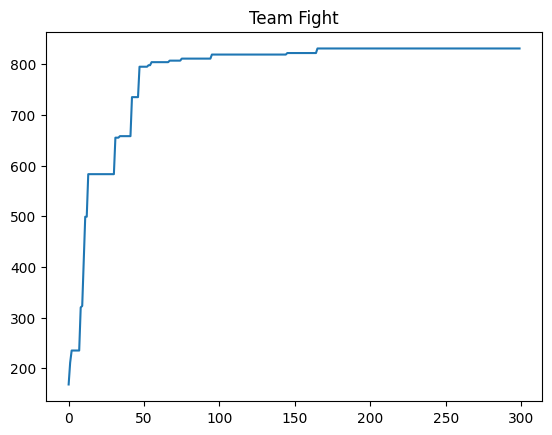

In [23]:
def calculate_fitness(individual, target_positions, team_strategy):
    fitness_value = 0
    for player, position in zip(individual, target_positions):
        if player['Position'] == position:
            if team_strategy == 1:
                fitness_value += player['Overall']
            elif team_strategy == 0:
                fitness_value += player['Overall']
    return fitness_value

def tournament_selection(population, fitness_values, tournament_size):
    selected_parents = []
    for _ in range(len(population)):
        tournament_candidates_indices = random.sample(range(len(population)), tournament_size)
        tournament_candidates_fitness = [fitness_values[i] for i in tournament_candidates_indices]
        winner_index = tournament_candidates_indices[np.argmax(tournament_candidates_fitness)]
        selected_parents.append(population[winner_index])
    return selected_parents

def crossover(parent1, parent2):
    crossover_point = random.randint(0, len(parent1) - 1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    
    # Ensure no duplicate players in children
    child1 = remove_duplicates(child1, player_data)
    child2 = remove_duplicates(child2, player_data)

    return child1, child2

def mutate(individual, player_data, mutation_rate):
    for i in range(len(individual)):
        if random.uniform(0, 1) < mutation_rate:
            new_player = random.choice(player_data)
            while new_player['Name'] in [player['Name'] for player in individual]:
                new_player = random.choice(player_data)
            individual[i] = new_player
    return individual

def remove_duplicates(individual, player_data):
    seen_names = set()
    unique_individual = []
    for player in individual:
        if player['Name'] not in seen_names:
            unique_individual.append(player)
            seen_names.add(player['Name'])
    while len(unique_individual) < len(individual):
        new_player = random.choice(player_data)
        while new_player['Name'] in seen_names:
            new_player = random.choice(player_data)
        unique_individual.append(new_player)
        seen_names.add(new_player['Name'])
    return unique_individual

def genetic_algorithm(population, player_data, target_positions, generations, tournament_size, crossover_rate, mutation_rate, team_strategy, pop_size):
    temp_result = []
    best_individual = None
    best_fitness = float('-inf')

    for generation in range(generations):
        fitness_values = [calculate_fitness(individual, target_positions, team_strategy) for individual in population]

        # Keep track of the best individual in the current generation
        max_fitness = max(fitness_values)
        if max_fitness > best_fitness:
            best_fitness = max_fitness
            best_individual = population[np.argmax(fitness_values)]

        # Tournament selection
        parents = tournament_selection(population, fitness_values, tournament_size)

        # Crossover
        children = []
        for parent1, parent2 in zip(parents[::2], parents[1::2] + [None]):
            if parent2 is not None:
                if random.uniform(0, 1) < crossover_rate:
                    child1, child2 = crossover(parent1, parent2)
                    children.append(child1)
                    children.append(child2)
                else:
                    children.append(parent1)
                    children.append(parent2)
            else:
                # Handle the case where the number of parents is odd
                children.append(parent1)

        # Mutation
        mutated_children = [mutate(child, player_data, mutation_rate) for child in children]

        # Combine old and new populations, then select the best individuals
        combined_population = population + mutated_children
        fitness_values_combined = [calculate_fitness(individual, target_positions, team_strategy) for individual in combined_population]
        best_indices_combined = np.argsort(fitness_values_combined)[-pop_size:]
        population = [combined_population[i] for i in best_indices_combined]

        # Print results for each generation
        temp_result.append(best_fitness)
        print(f"Generation {generation + 1}, Best Fitness: {best_fitness}")
    
        # Pilih individu terbaik dari populasi terakhir
    fitness_values = [calculate_fitness(individual, target_positions, team_strategy) for individual in population]
    best_individual_index = np.argmax(fitness_values)
    best_individual = population[best_individual_index]


    return best_individual, temp_result


player_data = df[df['Club'] == 'Manchester City'].to_dict(orient='records')

# Inisialisasi populasi
pop_size = 10
population = []

for _ in range(pop_size):
    # Ambil 11 player secara acak dari player_data
    team = random.sample(player_data, 11)  # Hanya ambil 11 player, mengabaikan 'Badang'
    population.append(team)

# Inisialisasi populasi
initial_population = population

# Parameter algoritma genetika
# target_positions = ['Gold Lane', 'Mid', 'EXP Lane', 'Roamer', 'Jungler']
target_positions = ['GK', 'CB', 'CB', 'LB', 'RB', 'LM', 'CM', 'RM', 'RW', 'LW', 'ST']
team_strategy = 1 # 0 for hard_engage and 1 for team_fight
generations = 300
tournament_size = 3
crossover_rate = 0.8
mutation_rate = 0.1

# Jalankan algoritma genetika
result, temp_result = genetic_algorithm(population, player_data, target_positions, generations, tournament_size, crossover_rate, mutation_rate, team_strategy, pop_size)

# Cetak hasil individu terbaik
print("Individu Terbaik:")
best_teams = result
for player in best_teams:
    print(f"Name: {player['Name']}, Position: {player['Position']}")

if(team_strategy == 0):
    plt.plot((temp_result))
    plt.title("Hard Engage")
    plt.show()
elif(team_strategy == 1):
    plt.plot((temp_result))
    plt.title("Team Fight")
    plt.show()